<h2 style="text-align:center;font-size:200%;;">Women's Shoes EDA & Modeling</h2>
<h3  style="text-align:center;">Keywords : 
    <span style="border-radius:7px;background-color:limegreen;color:white;padding:7px;">EDA</span>
    <span style="border-radius:7px;background-color:limegreen;color:white;padding:7px;">Pre-processing</span>
    <span style="border-radius:7px;background-color:limegreen;color:white;padding:7px;">Sales Analysis</span>
    <span style="border-radius:7px;background-color:limegreen;color:white;padding:7px;">Recommendation</span>
</h3>

<hr>

<h2 style="font-size:150%;"><span id='top'>Table of Contents</span></h2>
<blockquote>
    <ol>
        <li><a href="#Overview">Overview</a></li>
        <ul>
            <li><a href="#Project-detail">Project detail</a></li>
            <li><a href="#Goal-of-this-notebook">Goal of this notebook</a></li>
        </ul>
        <li><a href="#Import-libraries">Import libraries</a></li>
        <li><a href="#Load-the-dataset">Load the dataset</a></li>
        <li><a href="#Pre-processing">Pre-processing</a></li>
        <ul>
            <li><a href="#Currency-Pre-processing">Currency Pre-processing</a></li>
            <li><a href="#Brand-Normalization">Brand Normalization</a></li>
            <li><a href="#Category-Extraction">Category Extraction</a></li>
            <li><a href="#Description-Extraction">Description Extraction</a></li>
            <li><a href="#Reviews-Decomposition">Reviews Decomposition</a></li>
        </ul>
        <li><a href="#EDA">EDA</a></li>
        <ul>
            <li><a href="#Brand-Analysis">Brand Analysis</a></li>
            <li><a href="#Color-Analysis">Color Analysis</a></li> 
            <li><a href="#Price-Analysis">Price Analysis</a></li>
        </ul>
        <li><a href="#Modeling">Modeling</a></li>
        <ul>
            <li><a href="#Recommendation">Recommendation</a></li>
            <ul>
                <li><a href="#Algorithm-Design">Algorithm Design</a></li>
                <li><a href="#Output-Sample">Output Sample</a></li>
            </ul>
        </ul>
        <li><a href="#References">References</a></li>
    </ol>
</blockquote>

# <div style="text-align: left; background-color: mediumseagreen; color: white; padding: 10px; line-height:1;border-radius:10px">Overview</div>
## Project detail
In [this project](https://www.kaggle.com/datafiniti/womens-shoes-prices), the information about shoe brands such as price, color and categories are given by [Datafiniti's Product Database](https://datafiniti.co/products/product-data/).
* id
* brand
* categories
* colors
* manufacturer
* name
* price
* imageURL

## Goal of this notebook
* Practice EDA technique
* Practice visualization technique
* Recommendation System

<button class="label alert-success" style="border-radius:10px;padding:10px;font-size:18px"><a href="#top" style="color:green;"><b>Table of Contents</b></a></button>

# <div style="text-align: left; background-color: mediumseagreen; color: white; padding:10px; line-height: 1;border-radius:10px">Import libraries</div>

In [ ]:
!pip install sentence_transformers

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
import os
import collections
import json
from wordcloud import WordCloud
from PIL import Image
import requests
import io
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
from sentence_transformers import SentenceTransformer, util
from operator import itemgetter

# <div style="text-align: left; background-color: mediumseagreen; color: white; padding: 10px; line-height: 1;border-radius:10px">Load the dataset</div>

In [ ]:
datadir = "/kaggle/input"

In [ ]:
for dirname, _, filenames in os.walk(datadir):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
data = pd.read_csv(f"{datadir}/7210_1.csv")
print(f'7210_1.csv : {data.shape}')
data.head(3)

<button class="label alert-success" style="border-radius:10px;padding:10px;font-size:18px"><a href="#top" style="color:green;"><b>Table of Contents</b></a></button>

# <div style="text-align: left; background-color: mediumseagreen; color: white; padding: 10px; line-height: 1;border-radius:10px">Pre-processing</div>

In [ ]:
data.columns

extract useful columns for analysis

In [ ]:
cols = ["brand", "categories", "colors", "name", "prices.amountMax", "prices.currency", "descriptions", "manufacturer", "reviews", "prices.size"]
df = data[cols]
df.head(3)

In [ ]:
df = df.rename(columns={'prices.amountMax': 'price', 'prices.currency':'currency', 'prices.size':"size"})
df.head(3)

<button class="label alert-success" style="border-radius:10px;padding:10px;font-size:18px"><a href="#top" style="color:green;"><b>Table of Contents</b></a></button>

## Currency Pre-processing

There are some currecies other than USD.

In [ ]:
df.currency.value_counts()

function to convert into USD(thanks to [this notebook](https://www.kaggle.com/srlmayor/let-s-look-at-some-shoes))

In [ ]:
def curr_processing(x):
    if x.currency == 'AUD':
        x.price = x.price * 0.75
    if x.currency == 'CAD':
        x.price = x.price * 0.73
    if x.currency == 'EUR':
        x.price = x.price * 1.1
    return x

In [ ]:
df = df.apply(curr_processing, axis=1)
df.drop('currency', axis=1, inplace=True)
df.head(3)

## Brand Normalization
normalize brand names((thanks to [this notebook](https://www.kaggle.com/srlmayor/let-s-look-at-some-shoes)))

In [ ]:
df.loc[df['brand'].isin(['PUMA', 'Puma']), 'brand'] = 'PUMA'
df.loc[df['brand'].isin(['Lauren Ralph Lauren', 'Ralph Lauren']), 'brand'] = 'Ralph Lauren'
df.loc[df['brand'].isin(['MICHAEL Michael Kors', 'Michael Kors']), 'brand'] = 'Michael Kors'
df.loc[df['brand'].isin(['Pleaser Shoes', 'PleaserUSA', 'Pleaser']), 'brand'] = 'Pleaser'

<button class="label alert-success" style="border-radius:10px;padding:10px;font-size:18px"><a href="#top" style="color:green;"><b>Table of Contents</b></a></button>

## Category Extraction
Take a count by category

In [ ]:
df.categories[0]

In [ ]:
category_decomp = []
_ = df.categories.apply(lambda x: category_decomp.extend(x.split(",")))

In [ ]:
cats_counts = collections.Counter(category_decomp)

## Description Extraction

In [ ]:
df.descriptions[0]

There is some json formatting corruption, so exception handling should be added.

In [ ]:
def parse_desc(x):
    try:
        return json.loads(x)[0]["value"]
    except:
        return None

In [ ]:
df["desc_parsed"] = df.descriptions.apply(lambda x: parse_desc(x))

## Reviews Decomposition

In [ ]:
df.reviews[0]

In [ ]:
def review_decomp(x):
    try:
        reviews = json.loads(x)
    except:
        return None, None
    
    ratings = []
    texts = []
    for r in reviews:
        if "rating" in r:
            ratings.append(r["rating"])
        if "text" in r: 
            texts.append(r["text"])        
    if len(ratings) == 0:
        ratings = None
    else:
        ratings = np.mean(ratings)
    if len(texts) == 0: texts = None
    
    return texts, ratings

In [ ]:
df[["review_texts","mean_rating"]] = df.apply(lambda x: review_decomp(x.reviews) ,axis=1,result_type='expand')

<button class="label alert-success" style="border-radius:10px;padding:10px;font-size:18px"><a href="#top" style="color:green;"><b>Table of Contents</b></a></button>

# <div style="text-align: left; background-color: mediumseagreen; color: white; padding: 10px; line-height:1;border-radius:10px">EDA</div>

## Brand Analysis
<div class="alert alert-success" role="alert" style="border-radius:10px">
<ul>
    <li>sport fashion brands such as <u>Nike and Adidas</u> is cheaper than popular fashion brands.</li>
    <li><u>sport fashion brands has more vivid colors</u> such as <b>white, red, orange and blue</b> compared to high brand's black or brown.</li>
    <li>some brands'distribution have two peaks, which shows <u>these brands target two market groups such that reasonable and luxurious</u>.</li>
</ul>
</div>

In [ ]:
brand_cnt = df['brand'].value_counts() > 150
hv.Bars(df['brand'].value_counts()[brand_cnt][::-1]).opts(title="Brand Count over 150", color="purple", xlabel="Brand", ylabel="Count")\
                .opts(opts.Bars(width=600, height=600,tools=['hover'],show_grid=True,invert_axes=True))

In [ ]:
col_cnt = df['colors'].value_counts() > 100
col = hv.Bars(df['colors'].value_counts()[col_cnt][::-1]).opts(title="Colors Count over 100", color="purple", xlabel="Colors", ylabel="Count")\
                .opts(opts.Bars(width=400, height=300,tools=['hover'],show_grid=True,invert_axes=True,fontsize={'title':10}))
pr = hv.Distribution(df['price']).opts(title="Price Distribution", color="purple", xlabel="Price", ylabel="Density",xformatter='$ %d')\
                            .opts(opts.Distribution(width=400, height=300,tools=['hover'],show_grid=True))
col + pr

>Pick up some brands from over 100 counts brands.

In [ ]:
ralph_lauren = df[df.brand == 'Ralph Lauren']
novica = df[df.brand == "Novica"]
journee_collection = df[df.brand == "Journee Collection"]
propet = df[df.brand == "Propet"]
nike = df[df.brand == "Nike"]
adidas = df[df.brand == "Adidas"]

In [ ]:
def wordcloud_mask(img_url, text, _title):
    _img = io.BytesIO(requests.get(img_url).content)
    _mask_img = np.array(Image.open( _img ))
    wordcloud = WordCloud(background_color='white',width=800, height=600, \
                          min_font_size=1, max_words=None, collocations=False, min_word_length=1,  mask=_mask_img, contour_width =1, contour_color="#f5f5f5")
    wordcloud.generate(text)
    plt.figure(figsize=(10, 10))
    plt.title(_title, fontsize=20)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()

<button class="label alert-success" style="border-radius:10px;padding:10px;font-size:18px"><a href="#top" style="color:green;"><b>Table of Contents</b></a></button>

### Ralph Lauren

In [ ]:
rl_col_cnt = ralph_lauren['colors'].value_counts() > 10
col = hv.Bars(ralph_lauren['colors'].value_counts()[rl_col_cnt][::-1]).opts(title="Ralph Lauren Colors Count over 10", color="green", xlabel="Colors", ylabel="Count")\
                .opts(opts.Bars(width=400, height=300,tools=['hover'],show_grid=True,invert_axes=True,fontsize={'title':9}))
pr = hv.Distribution(ralph_lauren['price']).opts(title="Ralph Lauren Price Distribution", color="green", xlabel="Price", ylabel="Density",xformatter='$ %d')\
                            .opts(opts.Distribution(width=400, height=300,tools=['hover'],show_grid=True))
col + pr

In [ ]:
text = " ".join( ralph_lauren.query(" desc_parsed == desc_parsed ").desc_parsed.values )
wordcloud_mask("https://m.media-amazon.com/images/I/61QTiPeB2eL._AC_SR255,340_.jpg", text, "Ralph Lauren")

### Novica

In [ ]:
nvc_col_cnt = novica['colors'].value_counts() > 10
col = hv.Bars(novica['colors'].value_counts()[nvc_col_cnt][::-1]).opts(title="Novica Colors Count over 10", color="green", xlabel="Colors", ylabel="Count")\
                .opts(opts.Bars(width=400, height=300,tools=['hover'],show_grid=True,invert_axes=True,fontsize={'title':9}))
pr = hv.Distribution(novica['price']).opts(title="Novica Price Distribution", color="green", xlabel="Price", ylabel="Density",xformatter='$ %d')\
                            .opts(opts.Distribution(width=400, height=300,tools=['hover'],show_grid=True))
col + pr

In [ ]:
text = " ".join( novica.query(" desc_parsed == desc_parsed ").desc_parsed.values )
wordcloud_mask("https://i.ebayimg.com/images/g/2o8AAOSwIttiScpY/s-l1600.jpg", text, "Novica")

### Journee Collection

In [ ]:
jnc_col_cnt = journee_collection['colors'].value_counts() > 30
col = hv.Bars(journee_collection['colors'].value_counts()[jnc_col_cnt][::-1]).opts(title="Journee Collection Colors Count over 30", color="green", xlabel="Colors", ylabel="Count")\
                .opts(opts.Bars(width=500, height=300,tools=['hover'],show_grid=True,invert_axes=True,fontsize={'title':7}))
pr = hv.Distribution(journee_collection['price']).opts(title="Journee Collection Price Distribution", color="green", xlabel="Price", ylabel="Density",xformatter='$ %d')\
                            .opts(opts.Distribution(width=300, height=300,tools=['hover'],show_grid=True,fontsize={'title':9}))
col + pr

In [ ]:
text = " ".join( journee_collection.query(" desc_parsed == desc_parsed ").desc_parsed.values )
wordcloud_mask("https://tshop.r10s.jp/sangashoes/cabinet/te1901/1763-030633463337701.jpg?fitin=720%3A720", text, "Journee Collection")

<button class="label alert-success" style="border-radius:10px;padding:10px;font-size:18px"><a href="#top" style="color:green;"><b>Table of Contents</b></a></button>

### Nike

In [ ]:
nk_col_cnt = nike['colors'].value_counts() > 10
col = hv.Bars(nike['colors'].value_counts()[nk_col_cnt][::-1]).opts(title="Nike Colors Count over 10", color="green", xlabel="Colors", ylabel="Count")\
                .opts(opts.Bars(width=400, height=300,tools=['hover'],show_grid=True,invert_axes=True))
pr = hv.Distribution(nike['price']).opts(title="Nike Price Distribution", color="green", xlabel="Price", ylabel="Density",xformatter='$ %d')\
                            .opts(opts.Distribution(width=400, height=300,tools=['hover'],show_grid=True))
col + pr

In [ ]:
text = " ".join( nike.query(" desc_parsed == desc_parsed ").desc_parsed.values )
wordcloud_mask("https://assetscdn1.paytm.com/images/catalog/product/F/FO/FOONIKE-WOMEN-SSMAR26297E1BA5F07/1564617367666_0..jpg", text, "Nike")

### Adidas

In [ ]:
ad_col_cnt = adidas['colors'].value_counts() > 10
col = hv.Bars(adidas['colors'].value_counts()[ad_col_cnt][::-1]).opts(title="Adidas Colors Count over 10", color="green", xlabel="Colors", ylabel="Count")\
                .opts(opts.Bars(width=400, height=300,tools=['hover'],show_grid=True,invert_axes=True))
pr = hv.Distribution(adidas['price']).opts(title="Adidas Price Distribution", color="green", xlabel="Price", ylabel="Density",xformatter='$ %d')\
                            .opts(opts.Distribution(width=400, height=300,tools=['hover'],show_grid=True))
col + pr

In [ ]:
text = " ".join( adidas.query(" desc_parsed == desc_parsed ").desc_parsed.values )
wordcloud_mask("https://kutsu.com/client_info/CHIYODA/itemimage/430862430/430862430_1.jpg", text, "Adidas")

### Propet

In [ ]:
pp_col_cnt = propet['colors'].value_counts() > 10
col = hv.Bars(propet['colors'].value_counts()[pp_col_cnt][::-1]).opts(title="Propet Colors Count over 10", color="green", xlabel="Colors", ylabel="Count")\
                .opts(opts.Bars(width=400, height=300,tools=['hover'],show_grid=True,invert_axes=True))
pr = hv.Distribution(propet['price']).opts(title="Propet Price Distribution", color="green", xlabel="Price", ylabel="Density",xformatter='$ %d')\
                            .opts(opts.Distribution(width=400, height=300,tools=['hover'],show_grid=True))
col + pr

In [ ]:
text = " ".join( propet.query(" desc_parsed == desc_parsed ").desc_parsed.values )
wordcloud_mask("https://m.media-amazon.com/images/I/71i2VrNCLDL._AC_UX500_.jpg", text, "Propet")

<button class="label alert-success" style="border-radius:10px;padding:10px;font-size:18px"><a href="#top" style="color:green;"><b>Table of Contents</b></a></button>

## Color Analysis
<div class="alert alert-success" role="alert" style="border-radius:10px">
<ul>
    <li><u>Black,white and brown</u> shoes' price have multiple peaks.</li>
    <li>High brands such as <b>Ralph Lauren</b> have many items of dark colors, which leads an outlier peak.</li>
</ul>
</div>

In [ ]:
col_cnt = df['colors'].value_counts() > 50
hv.Bars(df['colors'].value_counts()[col_cnt][::-1]).opts(title="Colors Count over 50", color="purple", xlabel="Colors", ylabel="Count")\
                .opts(opts.Bars(width=600, height=600,tools=['hover'],show_grid=True,invert_axes=True,fontsize={'title':10}))

Pick up some famuous and lovely colors from above colors.

In [ ]:
black = df[df.colors == "Black"]
white = df[df.colors == "White"]
blue = df[df.colors == "Blue"]
brown = df[df.colors == "Brown"]
red = df[df.colors == "Red"]
pink = df[df.colors == "Pink"]
silver = df[df.colors == "Silver"]
orange = df[df.colors == "Orange"]

<button class="label alert-success" style="border-radius:10px;padding:10px;font-size:18px"><a href="#top" style="color:green;"><b>Table of Contents</b></a></button>

### Black

In [ ]:
bl_br_cnt = black['brand'].value_counts() > 30
br = hv.Bars(black['brand'].value_counts()[bl_br_cnt][::-1]).opts(title="Brand Count with Black over 30", color="black", xlabel="Brands", ylabel="Count")\
                .opts(opts.Bars(width=400, height=300,tools=['hover'],show_grid=True,invert_axes=True))
pr = hv.Distribution(black['price']).opts(title="Price Distribution with Black", color="black", xlabel="Price", ylabel="Density",xformatter='$ %d')\
                            .opts(opts.Distribution(width=400, height=300,tools=['hover'],show_grid=True))
br + pr

### White

In [ ]:
wh_br_cnt = white['brand'].value_counts() > 10
br = hv.Bars(white['brand'].value_counts()[wh_br_cnt][::-1]).opts(title="Brand Count with White over 10", color="white", xlabel="Brands", ylabel="Count")\
                .opts(opts.Bars(width=400, height=300,tools=['hover'],show_grid=True,invert_axes=True))
pr = hv.Distribution(white['price']).opts(title="Price Distribution with White", color="white", xlabel="Price", ylabel="Density",xformatter='$ %d')\
                            .opts(opts.Distribution(width=400, height=300,tools=['hover'],show_grid=True))
br + pr

### Blue

In [ ]:
bl_br_cnt = blue['brand'].value_counts() > 10
br = hv.Bars(blue['brand'].value_counts()[bl_br_cnt][::-1]).opts(title="Brand Count with Blue over 10", color="blue", xlabel="Brands", ylabel="Count")\
                .opts(opts.Bars(width=400, height=300,tools=['hover'],show_grid=True,invert_axes=True))
pr = hv.Distribution(blue['price']).opts(title="Price Distribution with Blue", color="blue", xlabel="Price", ylabel="Density",xformatter='$ %d')\
                            .opts(opts.Distribution(width=400, height=300,tools=['hover'],show_grid=True))
br + pr

<button class="label alert-success" style="border-radius:10px;padding:10px;font-size:18px"><a href="#top" style="color:green;"><b>Table of Contents</b></a></button>

### Brown

In [ ]:
br_br_cnt = brown['brand'].value_counts() > 10
br = hv.Bars(brown['brand'].value_counts()[br_br_cnt][::-1]).opts(title="Brand Count with Brown over 10", color="brown", xlabel="Brands", ylabel="Count")\
                .opts(opts.Bars(width=400, height=300,tools=['hover'],show_grid=True,invert_axes=True))
pr = hv.Distribution(brown['price']).opts(title="Price Distribution with Brown", color="brown", xlabel="Price", ylabel="Density",xformatter='$ %d')\
                            .opts(opts.Distribution(width=400, height=300,tools=['hover'],show_grid=True))
br + pr

### Red

In [ ]:
rd_br_cnt = red['brand'].value_counts() > 10
br = hv.Bars(red['brand'].value_counts()[rd_br_cnt][::-1]).opts(title="Brand Count with Red over 10", color="red", xlabel="Brands", ylabel="Count")\
                .opts(opts.Bars(width=400, height=300,tools=['hover'],show_grid=True,invert_axes=True))
pr = hv.Distribution(red['price']).opts(title="Price Distribution with Red", color="red", xlabel="Price", ylabel="Density",xformatter='$ %d')\
                            .opts(opts.Distribution(width=400, height=300,tools=['hover'],show_grid=True))
br + pr

### Pink

In [ ]:
pk_br_cnt = pink['brand'].value_counts() > 10
br = hv.Bars(pink['brand'].value_counts()[pk_br_cnt][::-1]).opts(title="Brand Count with Pink over 10", color="pink", xlabel="Brands", ylabel="Count")\
                .opts(opts.Bars(width=400, height=300,tools=['hover'],show_grid=True,invert_axes=True))
pr = hv.Distribution(pink['price']).opts(title="Price Distribution with Pink", color="pink", xlabel="Price", ylabel="Density",xformatter='$ %d')\
                            .opts(opts.Distribution(width=400, height=300,tools=['hover'],show_grid=True))
br + pr

<button class="label alert-success" style="border-radius:10px;padding:10px;font-size:18px"><a href="#top" style="color:green;"><b>Table of Contents</b></a></button>

### Silver

In [ ]:
sl_br_cnt = silver['brand'].value_counts() > 10
br = hv.Bars(silver['brand'].value_counts()[sl_br_cnt][::-1]).opts(title="Brand Count with Silver over 10", color="silver", xlabel="Brands", ylabel="Count")\
                .opts(opts.Bars(width=400, height=300,tools=['hover'],show_grid=True,invert_axes=True))
pr = hv.Distribution(silver['price']).opts(title="Price Distribution with Silver", color="silver", xlabel="Price", ylabel="Density",xformatter='$ %d')\
                            .opts(opts.Distribution(width=400, height=300,tools=['hover'],show_grid=True))
br + pr

### Orange

In [ ]:
or_br_cnt = orange['brand'].value_counts() > 5
br = hv.Bars(orange['brand'].value_counts()[or_br_cnt][::-1]).opts(title="Brand Count with Orange over 5", color="orange", xlabel="Brands", ylabel="Count")\
                .opts(opts.Bars(width=400, height=300,tools=['hover'],show_grid=True,invert_axes=True,fontsize={'title':10}))
pr = hv.Distribution(orange['price']).opts(title="Price Distribution with Orange", color="orange", xlabel="Price", ylabel="Density",xformatter='$ %d')\
                            .opts(opts.Distribution(width=400, height=300,tools=['hover'],show_grid=True))
br + pr

<button class="label alert-success" style="border-radius:10px;padding:10px;font-size:18px"><a href="#top" style="color:green;"><b>Table of Contents</b></a></button>

## Price Analysis

In [ ]:
hv.Distribution(df['price']).opts(title="Price Distribution", color="purple", xlabel="Price", ylabel="Density")\
                            .opts(opts.Distribution(width=700, height=300,tools=['hover'],show_grid=True,xformatter='$ %d'))

<div class="alert alert-success" role="alert" style="border-radius:10px">
According to <a href='https://datafiniti.co/cost-of-designer-label/'>this report</a>, brands can be classified into these 3 groups.
<ul>
<li><b>Normal Pricing</b> : The price bucket counts follow a normal distribution for this brand.</li>
<li><b>Premium Anchor</b> : This brand has multiple products priced significantly higher than the largest cluster of prices.</li>
<li><b>Double Dip</b> : There are 2 more overlapping normal distributions of prices for this brand.</li>
</ul>
</div>

In [ ]:
#Normal Pricing
tory_burch = df[df.brand == 'Tory Burch']
diane_von_furstenberg = df[df.brand == 'Diane von Furstenberg']
ferragamo = df[df.brand == 'Ferragamo']
#Premium Anchor
prada = df[df.brand.isin(['PRADA','Prada'])]
christian_louboutian = df[df.brand.isin(['Christian Louboutin'])]
fendi = df[df.brand.isin(['Fendi'])]
#Double Dip
burberry = df[df.brand.isin(['Burberry','BURBERRY'])]
d_and_g = df[df.brand.isin(['Dolce & Gabbana'])]
stella = df[df.brand.isin(['Stella McCartney'])]

### Normal Pricing

In [ ]:
tory_burch_g = hv.Distribution(tory_burch['price']).opts(title="Tory Burch Price Distribution", color="royalblue", xlabel="Price", ylabel="Density").opts(xlim=(0, 2500))
diane_von_furstenberg_g = hv.Distribution(diane_von_furstenberg['price']).opts(title="Diane von Furstenberg Price Distribution", color="royalblue", xlabel="Price", ylabel="Density")
ferragamo_g = hv.Distribution(ferragamo['price']).opts(title="Ferragamo Price Distribution", color="royalblue", xlabel="Price", ylabel="Density")
(tory_burch_g + diane_von_furstenberg_g + ferragamo_g).opts(opts.Distribution(width=800, height=200,tools=['hover'],show_grid=True, xformatter='$ %d')).cols(1)

### Premium Anchor

In [ ]:
prada_g = hv.Distribution(prada['price']).opts(title="Prada Price Distribution", color="springgreen", xlabel="Price", ylabel="Density").opts(xlim=(0, 2500))
christian_louboutian_g = hv.Distribution(christian_louboutian['price']).opts(title="Christian Louboutin Price Distribution", color="springgreen", xlabel="Price", ylabel="Density")
fendi_g = hv.Distribution(fendi['price']).opts(title="Fendi Price Distribution", color="springgreen", xlabel="Price", ylabel="Density")
(prada_g + christian_louboutian_g + fendi_g).opts(opts.Distribution(width=800, height=200,tools=['hover'],show_grid=True, xformatter='$ %d')).cols(1)

### Double Dip

In [ ]:
burberry_g = hv.Distribution(burberry['price']).opts(title="Burberry Price Distribution", color="darkturquoise", xlabel="Price", ylabel="Density").opts(xlim=(0, 2500))
d_and_g_g = hv.Distribution(d_and_g['price']).opts(title="Dolce & Gabbana Price Distribution", color="darkturquoise", xlabel="Price", ylabel="Density")
stella_g = hv.Distribution(stella['price']).opts(title="Stella McCartney Price Distribution", color="darkturquoise", xlabel="Price", ylabel="Density")
(burberry_g + d_and_g_g + stella_g).opts(opts.Distribution(width=800, height=200,tools=['hover'],show_grid=True, xformatter='$ %d')).cols(1)

<button class="label alert-success" style="border-radius:10px;padding:10px;font-size:18px"><a href="#top" style="color:green;"><b>Table of Contents</b></a></button>

# <div style="text-align: left; background-color: mediumseagreen; color: white; padding: 10px; line-height:1;border-radius:10px">Modeling</div>

## Recommendation

create dataframe for recommendation
* drop unnecessary columns
* drop duplicated rows
* complement column 'mean_rating' with its average

In [ ]:
rec_df = df.copy()
rec_df.drop(["categories","descriptions","manufacturer","reviews","review_texts","size"], axis=1, inplace=True)
rec_df = rec_df.dropna(subset=["brand","desc_parsed","colors"]).drop_duplicates()

In [ ]:
def get_mean_score(x):
    if x.mean_rating != x.mean_rating:
        _brand = x.brand
        _mean = rec_df.query(f"brand == \"{_brand}\" ").mean_rating.mean()
        if np.isnan(_mean):
            _mean = rec_df.mean_rating.mean()
        return _mean
    else:
        return x.mean_rating

In [ ]:
rec_df["mean_rating"] = rec_df.parallel_apply(lambda x: get_mean_score(x), axis=1 )

In [ ]:
rec_df.reset_index(inplace=True, drop=True)
rec_df.brand = rec_df.brand.apply(lambda x : x.lower() )
rec_df.colors = rec_df.colors.apply(lambda x : x.lower() )
rec_df.name = rec_df.name.apply(lambda x : x.lower() )
rec_df.desc_parsed = rec_df.desc_parsed.apply(lambda x : x.lower() )
rec_df.head()

### Algorithm Design

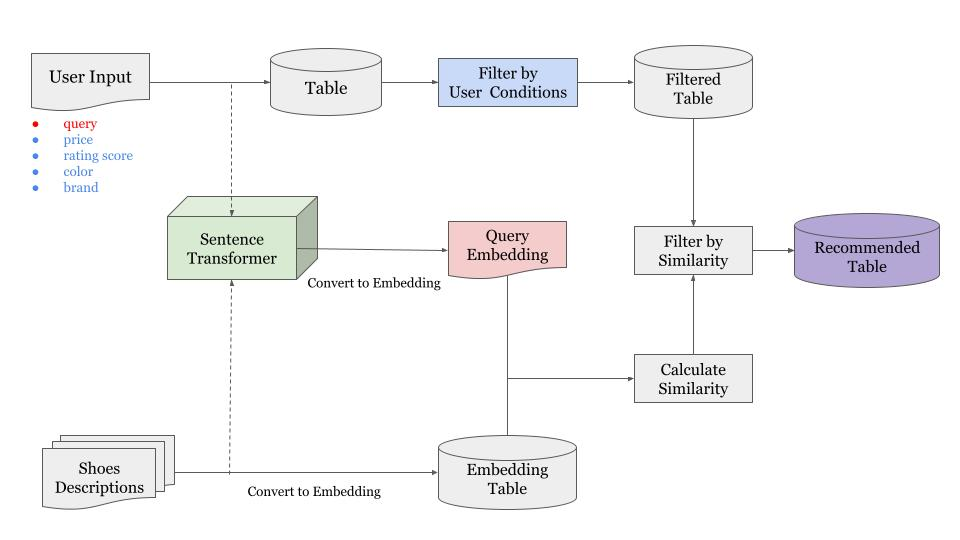

In [ ]:
model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')
desc_encoded = model.encode(rec_df.desc_parsed, show_progress_bar=True, convert_to_numpy=True)

In [ ]:
pd.options.display.max_colwidth = 100
def query_based_recommend(query, price_range, score_range, color, brand, topn, embedding_table = desc_encoded):
    # embed user query
    query_emb = model.encode(query,show_progress_bar=False, convert_to_numpy=True)
    
    # filter by conditions
    _price = "( price >= @price_range[0] & price <= @price_range[1] )"
    _score = "( mean_rating >= @score_range[0] & mean_rating <= @score_range[1] )"
    if color == "*":
         _colors = "( colors == colors )"
    else:
        _colors = "( colors.str.contains(@color) )"
    if brand == "*":
        _brand = "( brand == brand )"
    else:
        _brand = "( brand.str.contains(@brand) )"
    filtered_df = rec_df.query(f"{_price} and {_score} and {_colors} and {_brand}", engine='python')
    
    # calculate similarity score
    filtered_index = filtered_df.index
    filtered_emb_table = list( itemgetter(filtered_index)(embedding_table) )
    sim_scores = util.cos_sim(query_emb, filtered_emb_table)
    
    # get index order by similarity
    sim_top_index = np.argsort(sim_scores, axis=1)[0].tolist()[::-1]
    sim_df = filtered_df.iloc[sim_top_index, :][0:topn]

    return sim_df[["brand","name","colors","price"]]

<button class="label alert-success" style="border-radius:10px;padding:10px;font-size:18px"><a href="#top" style="color:green;"><b>Table of Contents</b></a></button>

### Output Sample

In [ ]:
query_based_recommend(
    query="sporty cute",
    price_range=[0,100],
    score_range=[0,5],
    color="blue",
    brand="*",
    topn=5
)

In [ ]:
query_based_recommend(
    query="cool beauty",
    price_range=[0,50],
    score_range=[0,3],
    color="black",
    brand="*",
    topn=5
)

In [ ]:
query_based_recommend(
    query="comfortable sports shoes",
    price_range=[0,30],
    score_range=[4,5],
    color="*",
    brand="*",
    topn=5
)

# <div style="text-align: left; background-color: mediumseagreen; color: white; padding: 10px; line-height:1;border-radius:10px">References</div>
* Good EDA notebook  
    * https://www.kaggle.com/srlmayor/let-s-look-at-some-shoes
* Datafiniti's Report using this dataset 
    * https://datafiniti.co/cost-of-designer-label/
* data schema
    * https://developer.datafiniti.co/docs/product-data-schema
* Sentence-BERT docs
    * https://www.sbert.net/examples/applications/computing-embeddings/README.html?input-sequence-length#sentence_transformers.SentenceTransformer.encode

<button class="label alert-success" style="border-radius:10px;padding:10px;font-size:18px"><a href="#top" style="color:green;"><b>Table of Contents</b></a></button>